In [ ]:
import numpy as np
from google.colab import drive
import skimage.io as io
import numpy as np
import os
import torch
import torchvision.transforms as T
from PIL import Image, ImageColor
from scipy import ndimage
from torch.utils.data import Dataset
from skimage.transform import resize
import random
from torch import nn
import torch.nn.functional as F
!pip install torchmetrics
from torchmetrics.classification import Dice
from torchmetrics import F1Score
import torch.nn.init as init
from PIL import ImageEnhance, Image
import random
import torch.optim as optim
#!pip install focal_loss_torch
#from focal_loss.focal_loss import FocalLoss

In [ ]:
drive.mount('/content/drive')
drive_path = 'drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
parts = {10: {'col': 'orange', 'name':'hood'},
         20: {'col':'darkgreen', 'name':'front door'},
         30: {'col':'yellow', 'name':'rear door'},
         40: {'col':'cyan', 'name':'frame'},
         50: {'col':'purple', 'name':'rear quarter panel'},
         60: {'col':'lightgreen', 'name':'trunk lid'},
         70: {'col':'blue', 'name':'fender'},
         80: {'col':'pink', 'name':'bumper'},
         90: {'col':'darkgray', 'name':'rest of car'},
         0 : {'col':'black', 'name':'background'}}

def display_car(data_arr):
    # Can take both full data and already split data
    if type(data_arr) == torch.Tensor: data_arr = np.moveaxis(data_arr.numpy().astype(np.uint8), 0, 2)
    elif data_arr.shape[0] == 3: data_arr = np.moveaxis(data_arr.astype(np.uint8), 0, 2)
    elif data_arr.shape[2] > 3: data_arr = data_arr[:,:,:3]
    img = Image.fromarray(data_arr)
    display(img) # img.show() for jupyter

def display_labels(data_arr):
    # Can take both full data and already split data
    if type(data_arr) == torch.Tensor: data_arr = data_arr.numpy()
    if data_arr.dtype != np.uint8: data_arr = data_arr.astype(np.uint8)*10
    if data_arr.ndim > 2: data_arr = data_arr[:,:,3]
    img = Image.fromarray(data_arr)
    pixels = list(img.getdata())
    pixels = [ImageColor.getrgb(parts.get(pixel)['col']) for pixel in pixels]
    image = Image.new("RGB", (256, 256), (0,0,0))
    image.putdata(pixels)
    display(image)

def numpy_to_tensor(arr):
    return np.moveaxis(arr, 2, 0).astype(np.float32)

def tensor_to_numpy(tens):
    arr = np.moveaxis(tens, 0, 2).astype(np.uint8)
    return arr

In [ ]:
def center_square(img):
    """Returns the cropped central square of an image (crops the largest dimension to match the smallest one)"""
    if img.size[0] == img.size[1]: return img
    smallest_dim = np.argmin(img.size)
    largest_dim = np.argmax(img.size)
    square_dim = img.size[smallest_dim]
    crop_dims = [0,0,0,0]
    crop_dims[largest_dim] = int(img.size[largest_dim]/2-square_dim/2)
    crop_dims[largest_dim+2] = int(img.size[largest_dim]/2+square_dim/2)
    crop_dims[smallest_dim] = 0
    crop_dims[smallest_dim+2] = img.size[smallest_dim]
    crop_img = img.crop(crop_dims)

    return crop_img

def set_background(car_arr, labels_arr, img):
    """Places all non-0 pixels of the car on the background img"""
    center_img = center_square(img)
    back_arr = np.array(center_img.resize(labels_arr.shape))
    # Use both car and labels just in case
    back_arr[labels_arr!=0] = car_arr[labels_arr!=0]

    # In the black car dataset, label pixel count should be similar to non-black pixel count
    if np.sum(car_arr!=0)/3 < np.sum(labels_arr!=0)*1.2:
        # In the black dataset, part of the car isn't correctly labeled, so also use car data for setting background
        back_arr[car_arr!=0] = car_arr[car_arr!=0]

    return back_arr

def move_full_car(arr, x, y, angle=0, zoom=1):
    """Moves the center of the car to (x, y). Takes the whole array (car AND labels)"""
    car_idxs = np.where(arr!=0)
    car_bbox = [max(0,np.min(car_idxs[1])-10), max(0,np.min(car_idxs[0])-10), min(255, np.max(car_idxs[1])+10), min(255,np.max(car_idxs[0])+10)]
    # Array with just the car
    car_arr = arr[car_bbox[1]:car_bbox[3],car_bbox[0]:car_bbox[2]]
    # Rotate the car
    car_arr = ndimage.rotate(car_arr, angle, reshape=True, order=0)
    car_arr = ndimage.zoom(car_arr, (zoom, zoom, 1), order=0)
    # Edges of the car in the new array (without taking into account new image borders)
    edges = [y-np.ceil(car_arr.shape[0]/2),y+np.floor(car_arr.shape[0]/2),x-np.ceil(car_arr.shape[1]/2),x+np.floor(car_arr.shape[1]/2)]
    # Where to crop the car if it goes off bounds
    car_limits = [max(0,-1*int(edges[0])), 255-int(edges[1]) if 255-int(edges[1]) < 0 else car_arr.shape[0], max(0,-1*int(edges[2])), 255-int(edges[3]) if 255-int(edges[3]) < 0 else car_arr.shape[1]]
    edges = [max(0,int(edges[0])), min(255, int(edges[1])), max(0,int(edges[2])), min(255, int(edges[3]))]

    new_arr = np.zeros(arr.shape)
    new_arr[edges[0]:edges[1],edges[2]:edges[3]] = car_arr[car_limits[0]:car_limits[1],car_limits[2]:car_limits[3]]

    return new_arr.astype(np.uint8)


In [ ]:
def load_images_from_folder(folder_path, resize_shape=(256, 256), limit=100):
    background_list = []
    count = 0

    for filename in os.listdir(folder_path):
        # Check if the file is an image file
        file_path = os.path.join(folder_path, filename)

        background = Image.open(file_path).convert('RGB')
        background_list.append(background)

        count += 1
        if count >= limit:
            break

    return background_list

folder_path = 'drive/My Drive/carseg_data/images/landscapes'
background_list = load_images_from_folder(folder_path, limit=250)

In [ ]:
class CarDataset(Dataset):
    def __init__(self, root, file_list: list=None, backgrounds: list=[], move_car: bool=False, rotate_car: bool=False, zoom_car: bool=False):
        """
        Initializes the dataset.
        Parameters:
            file_list: a list of filenames from 'root' to use. If not specified, all files will be used.
            background: list with backgrounds. If not specified, no backgrounds will be used.
            move_car: specifies if the cars should be moved to a random location in the image
            rotate_car: specifies if the cars should be given a random rotation (within a range)
        Backgrounds, rotations and translations are random. There is a chance that none will be performed at all.
        This chance is higher for 'photo' images, which will only be rotated/translated when the background is changed (to avoid black bars)
        """
        self.root = root
        self.filenames = os.listdir(self.root) if file_list is None else file_list
        self.backgrounds = backgrounds
        self.move_car = move_car
        self.rotate_car = rotate_car
        self.zoom_car = zoom_car

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        arr = np.load(os.path.join(self.root, filename))
        photo_mod = True
        if 'photo' in filename:
            # Photos only get new background with 33% chance
            photo_mod = random.randrange(0,3)==1

        if self.move_car:
            x = random.randrange(80,255-80)
            y = random.randrange(80,255-80)
            angle = random.randrange(-30,30) if self.rotate_car else 0
            zoom = random.uniform(0.7,1.5) if self.zoom_car else 1
            arr = move_full_car(arr, x, y, angle, zoom)

        car = arr[:,:,0:3]
        labels = arr[:,:,3]

        if len(self.backgrounds) > 0 and photo_mod:
            rand_idx = random.randrange(0,len(self.backgrounds))

            # Some backgrounds are RGB
            img = self.backgrounds[rand_idx]
            car = set_background(car, labels, img)

        car = np.moveaxis(car, 2, 0)


        return car, labels / 10


In [ ]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

black_car = []
orange_car = []
photos = []
for file in os.listdir(f'{drive_path}carseg_data/arrays'):
    if 'orange' in file: orange_car.append(file)
    elif 'black' in file: black_car.append(file)
    elif 'photo' in file and '(' not in file: photos.append(file)

root = f'{drive_path}carseg_data/arrays'


photo_test = photos[:30]
photos = photos[30:]

black_train, _ = train_test_split(black_car, test_size=0.1, random_state=42, shuffle=True)
orange_train, _ = train_test_split(orange_car, test_size=0.1, random_state=42, shuffle=True)
photos_train, photos_val = train_test_split(photos, test_size=0.2, random_state=42, shuffle=True)


photos_train_ds = CarDataset(root, photos_train*3+black_train[200:400]+orange_train[200:400])
train1_ds = CarDataset(root, photos_train*2, backgrounds=background_list)
train2_ds = CarDataset(root, black_train[:200]+orange_train[:200], rotate_car=True, move_car=True, zoom_car=True, backgrounds=background_list)

val_ds = CarDataset(root, photos_val)
test_ds = CarDataset(root, photo_test)


train_loader = DataLoader(photos_train_ds+train1_ds+train2_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader =  DataLoader(test_ds, batch_size=16)

In [ ]:
def test_model(model, test_loader, average_type):
  dice = Dice(average=average_type, num_classes=10)
  model.eval()
  dice_scores = []

  for batch in test_loader:
      inputs, labels = batch
      inputs, labels = batch
      inputs = inputs.to(device)
      labels = labels.to(device)

      inputs = inputs.float()
      labels = labels.long().to(device)

      with torch.no_grad():
          outputs = model(inputs)

          # Calculate accuracy on the test set
          _, pred = torch.max(outputs, 1)

          # Move tensors to CPU before performing numpy operations
          pred_cpu = pred.to('cpu')
          labels_cpu = labels.to('cpu')

          dice_scores.append(dice(pred_cpu, labels_cpu))

  return np.mean(dice_scores)

In [ ]:
def infere_display(model, car, labels):
    display_car(car)
    with torch.inference_mode():
        car = torch.tensor(car)
        car = car.to(device)
        car = car.float()
        car = car.unsqueeze(0)
        out = torch.nn.Softmax2d()(model(car)[0])
        out = np.moveaxis(out.cpu().numpy(), 0, 2)
        out = np.argmax(out, axis=2)
        display_labels(out)
        display_labels(labels)

# U-net model

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout2d(0.3)
        )

        for layer in self.block:
            if isinstance(layer, nn.Conv2d):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.encoder0 = nn.Sequential(ConvBlock(in_channels, 64))
        self.encoder1 = nn.Sequential(nn.MaxPool2d(2,2), ConvBlock(64, 128))
        self.encoder2 = nn.Sequential(nn.MaxPool2d(2,2), ConvBlock(128, 256))
        self.encoder3 = nn.Sequential(nn.MaxPool2d(2,2), ConvBlock(256, 512))
        self.bottleneck = nn.Sequential(nn.MaxPool2d(2,2), ConvBlock(512,1024), nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2))
        self.decoder0 = nn.Sequential(ConvBlock(1024,512), nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2))
        self.decoder1 = nn.Sequential(ConvBlock(512,256), nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2))
        self.decoder2 = nn.Sequential(ConvBlock(256,128), nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2))
        self.decoder3 = nn.Sequential(ConvBlock(128,64), nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1))

    def forward(self, x):
        x0 = self.encoder0(x)
        x1 = self.encoder1(x0)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.bottleneck(x3)
        x4 = self.decoder0(torch.cat([x3,x4],dim=1))
        x4 = self.decoder1(torch.cat([x2,x4],dim=1))
        x4 = self.decoder2(torch.cat([x1,x4],dim=1))
        x4 = self.decoder3(torch.cat([x0,x4],dim=1))

        return x4

In [ ]:
###!pip install segmentation_models_pytorch
#import segmentation_models_pytorch as smp

#model = smp.Unet(
#    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#    classes=10,                      # model output channels (number of classes in your dataset)
#)

Weighted crossentropy\
Combination of dice and crossentropy\
Focal loss\
Perceptual https://gist.github.com/alper111/8233cdb0414b4cb5853f2f730ab95a49

In [ ]:
import torch.optim as optim
#criterion = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss(weight = torch.tensor([0.5, 1, 1, 1, 1, 1, 1, 1, 1, 0.8]).to(device)) #weighted_CrossEntropyLoss
#criterion = FocalLoss(gamma=0.7) # Focal loss


## Cross entropy loss

In [ ]:
device = "cuda"
model = UNet(3, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)

checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/checkpoint_epoch_180.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

num_epochs = 250

dice = Dice(average='macro', num_classes=10)
dice_micro = Dice(average='micro')
dice_train = []
dice_val = []

for epoch in range(start_epoch, num_epochs):
    model.train()
    total_train_loss = 0.0
    dice_scores_train = 0


    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.float()
        labels = labels.long().to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        total_train_loss += loss.item()

        # Calculate dice
        _, pred = torch.max(outputs, 1)
        pred_cpu = pred.to('cpu')
        labels_cpu = labels.to('cpu')

        dice_scores_train += dice(pred_cpu, labels_cpu)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    dice_scores_val = 0
    micro_dice_scores_val = 0

    for batch in val_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.float()
        labels = labels.long().to(device)

        with torch.no_grad():
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

            # Calculate dice
            _, pred = torch.max(outputs, 1)
            pred_cpu = pred.to('cpu')
            labels_cpu = labels.to('cpu')

            dice_scores_val += dice(pred_cpu, labels_cpu)
            micro_dice_scores_val += dice_micro(pred_cpu, labels_cpu)


    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {(total_train_loss / len(train_loader)):.4f}, Train dice: {(dice_scores_train/len(train_loader)):.4f}, Val Loss: {(total_val_loss / len(val_loader)):.4f}, Val dice: {(dice_scores_val / len(val_loader)):.4f}, Val micro_dice: {(micro_dice_scores_val / len(val_loader)):.4f}")
    dice_train.append((dice_scores_train/len(train_loader)))
    dice_val.append((dice_scores_val/len(val_loader)))

    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/cross2_checkpoint_epoch_{epoch + 1}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': total_train_loss / len(train_loader),
            'val_loss': total_val_loss / len(val_loader),
            'train_dice': dice_scores_train / len(train_loader),
            'val_dice': dice_scores_val / len(val_loader),
            'val_micro_dice': micro_dice_scores_val / len(val_loader)
        }, checkpoint_path)
        print(f"Checkpoint {epoch+1} saved")


Epoch 181/250, Train Loss: 0.4679, Train dice: 0.5487, Val Loss: 0.5764, Val dice: 0.5285, Val micro_dice: 0.8366
Epoch 182/250, Train Loss: 0.4025, Train dice: 0.6168, Val Loss: 0.6274, Val dice: 0.5193, Val micro_dice: 0.8258
Epoch 183/250, Train Loss: 0.3514, Train dice: 0.6554, Val Loss: 0.4617, Val dice: 0.5938, Val micro_dice: 0.8574
Epoch 184/250, Train Loss: 0.3412, Train dice: 0.6631, Val Loss: 0.5278, Val dice: 0.5094, Val micro_dice: 0.8396
Epoch 185/250, Train Loss: 0.3273, Train dice: 0.6708, Val Loss: 0.4360, Val dice: 0.5793, Val micro_dice: 0.8614
Epoch 186/250, Train Loss: 0.3082, Train dice: 0.6848, Val Loss: 0.4871, Val dice: 0.5118, Val micro_dice: 0.8434
Epoch 187/250, Train Loss: 0.3016, Train dice: 0.6825, Val Loss: 0.4372, Val dice: 0.6418, Val micro_dice: 0.8638
Epoch 188/250, Train Loss: 0.2943, Train dice: 0.7003, Val Loss: 0.4942, Val dice: 0.5528, Val micro_dice: 0.8510
Epoch 189/250, Train Loss: 0.2862, Train dice: 0.7119, Val Loss: 0.4783, Val dice: 0.561

In [ ]:
torch.save(model.state_dict(), f'{drive_path}carseg_data/models/model_crossentropyloss3.pth')

In [ ]:
checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/checkpoint_epoch_230.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
multiclass_dice = F1Score(task='multiclass',num_classes=10,average="none")
model.eval()


for batch in test_loader:
    inputs, labels = batch
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    inputs = inputs.float()
    labels = labels.long().to(device)

    with torch.no_grad():
        outputs = model(inputs)

        # Calculate accuracy on the test set
        _, pred = torch.max(outputs, 1)

        # Move tensors to CPU before performing numpy operations
        pred_cpu = pred.to('cpu')
        labels_cpu = labels.to('cpu')
        m_dice = multiclass_dice(pred_cpu, labels_cpu)

    print(m_dice)



tensor([0.9531, 0.5854, 0.8371, 0.7780, 0.5923, 0.1515, 0.5047, 0.7726, 0.5721,
        0.8124])
tensor([0.9568, 0.7864, 0.8241, 0.5665, 0.3594, 0.1855, 0.1021, 0.6667, 0.7276,
        0.8083])


In [ ]:
macro = test_model(model, test_loader, "macro")
micro = test_model(model, test_loader, "micro")

print(f"Macro: {macro}")
print(f"Micro: {micro}")



Macro: 0.6271176338195801
Micro: 0.870222806930542


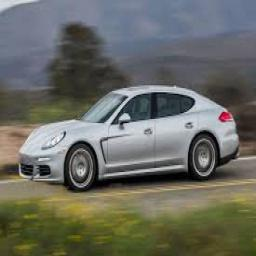

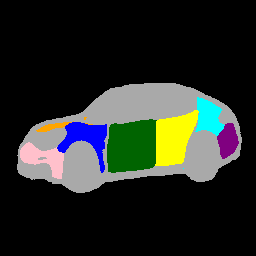

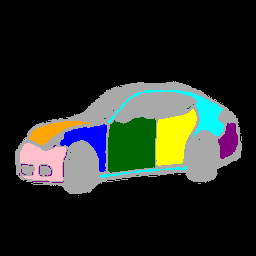

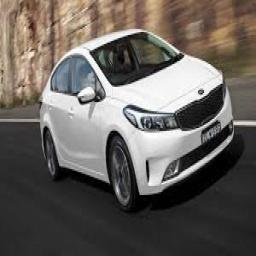

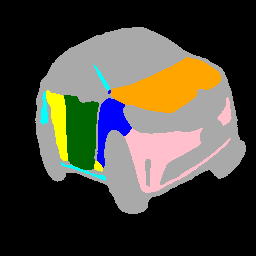

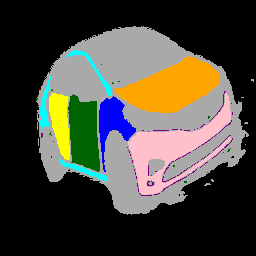

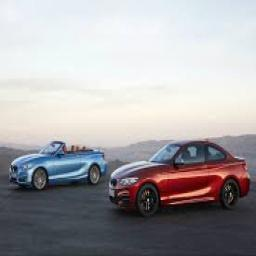

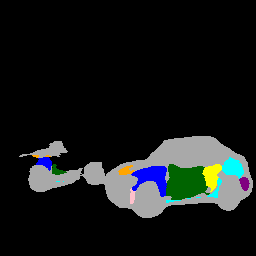

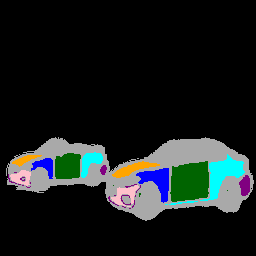

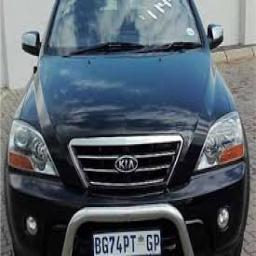

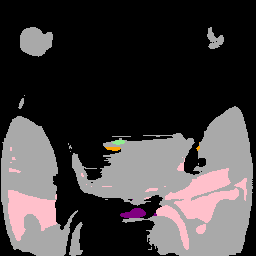

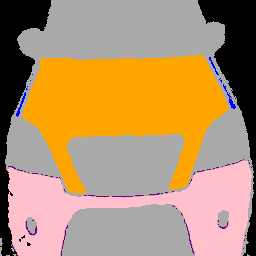

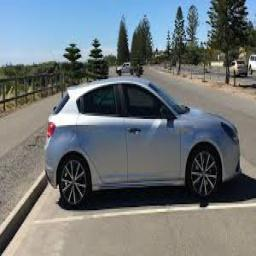

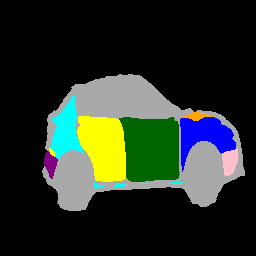

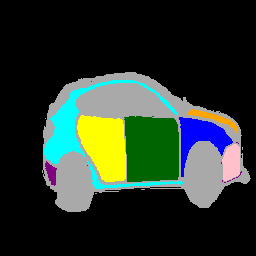

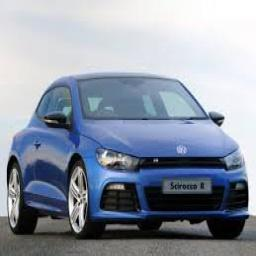

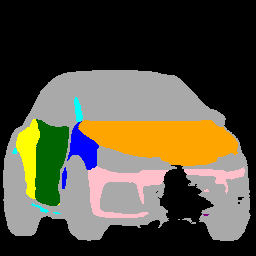

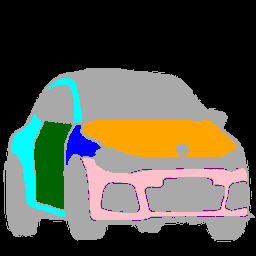

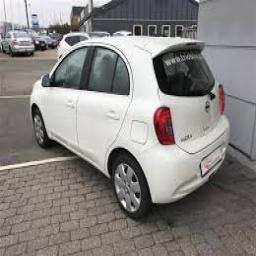

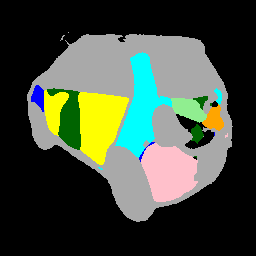

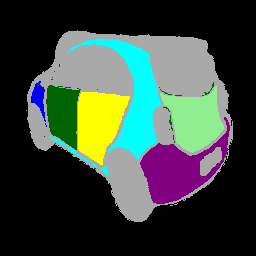

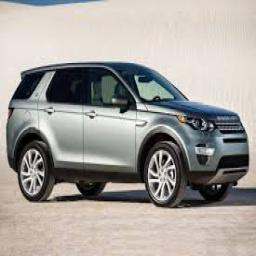

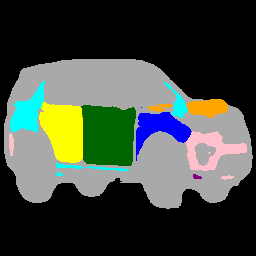

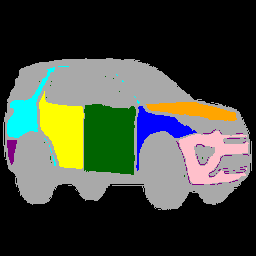

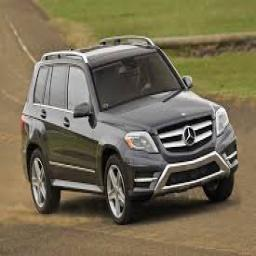

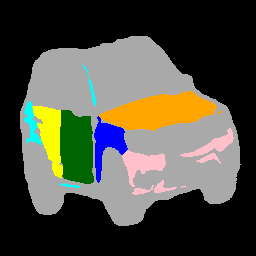

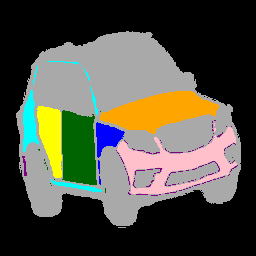

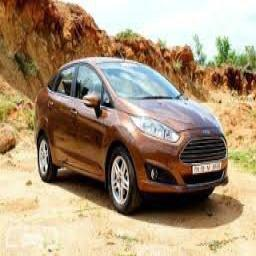

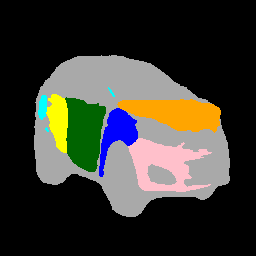

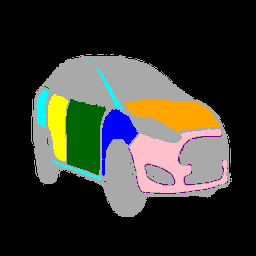

In [ ]:
for i in range(10):
  car, labels = test_ds[i]
  infere_display(model, car, labels)

## Weighted CrossEntropyLoss

In [ ]:
device = "cuda"
weighted_model = UNet(3, 10).to(device)
criterion = nn.CrossEntropyLoss(weight = torch.tensor([0.25, 1, 1, 1, 1, 1, 1, 1, 1, 0.5])).to(device)
optimizer = optim.Adam(weighted_model.parameters(), lr=0.005, weight_decay=1e-4)

checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/cross5_checkpoint_epoch_10.pth"
checkpoint = torch.load(checkpoint_path)
weighted_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = 0 #checkpoint['epoch'] + 1

num_epochs = 150

dice = Dice(average='macro', num_classes=10)
dice_micro = Dice(average='micro')
dice_train = []
dice_val = []

for epoch in range(start_epoch, num_epochs):
    weighted_model.train()
    total_train_loss = 0.0
    dice_scores_train = 0


    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.float()
        labels = labels.long().to(device)

        # Forward pass
        outputs = weighted_model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        total_train_loss += loss.item()

        # Calculate dice
        _, pred = torch.max(outputs, 1)
        pred_cpu = pred.to('cpu')
        labels_cpu = labels.to('cpu')

        dice_scores_train += dice(pred_cpu, labels_cpu)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    weighted_model.eval()
    total_val_loss = 0.0
    dice_scores_val = 0
    micro_dice_scores_val = 0

    for batch in val_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.float()
        labels = labels.long().to(device)

        with torch.no_grad():
            outputs = weighted_model(inputs)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

            # Calculate dice
            _, pred = torch.max(outputs, 1)
            pred_cpu = pred.to('cpu')
            labels_cpu = labels.to('cpu')

            dice_scores_val += dice(pred_cpu, labels_cpu)
            micro_dice_scores_val += dice_micro(pred_cpu, labels_cpu)


    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {(total_train_loss / len(train_loader)):.4f}, Train dice: {(dice_scores_train/len(train_loader)):.4f}, Val Loss: {(total_val_loss / len(val_loader)):.4f}, Val dice: {(dice_scores_val / len(val_loader)):.4f}, Val micro_dice: {(micro_dice_scores_val / len(val_loader)):.4f}")
    dice_train.append((dice_scores_train/len(train_loader)))
    dice_val.append((dice_scores_val/len(val_loader)))

    if (epoch + 1) % 5 == 0 or (dice_scores_val / len(val_loader)) > 0.6832:
        checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/cross5_checkpoint_epoch_{epoch + 1}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': weighted_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': total_train_loss / len(train_loader),
            'val_loss': total_val_loss / len(val_loader),
            'train_dice': dice_scores_train / len(train_loader),
            'val_dice': dice_scores_val / len(val_loader),
            'val_micro_dice': micro_dice_scores_val / len(val_loader)
        }, checkpoint_path)
        print(f"Checkpoint {epoch+1} saved")


Epoch 1/150, Train Loss: 1.1947, Train dice: 0.2103, Val Loss: 1.4228, Val dice: 0.1906, Val micro_dice: 0.6885
Epoch 2/150, Train Loss: 1.1917, Train dice: 0.2121, Val Loss: 1.3783, Val dice: 0.2070, Val micro_dice: 0.7382
Epoch 3/150, Train Loss: 1.1861, Train dice: 0.2181, Val Loss: 1.3950, Val dice: 0.2202, Val micro_dice: 0.7340
Epoch 4/150, Train Loss: 1.1733, Train dice: 0.2179, Val Loss: 1.4328, Val dice: 0.2091, Val micro_dice: 0.7322
Epoch 5/150, Train Loss: 1.1560, Train dice: 0.2230, Val Loss: 1.2779, Val dice: 0.2270, Val micro_dice: 0.7486
Checkpoint 5 saved
Epoch 6/150, Train Loss: 1.1543, Train dice: 0.2258, Val Loss: 1.3864, Val dice: 0.1960, Val micro_dice: 0.6987
Epoch 7/150, Train Loss: 1.1459, Train dice: 0.2406, Val Loss: 1.2651, Val dice: 0.2528, Val micro_dice: 0.7558
Epoch 8/150, Train Loss: 1.1254, Train dice: 0.2502, Val Loss: 1.3048, Val dice: 0.2381, Val micro_dice: 0.7190
Epoch 9/150, Train Loss: 1.1175, Train dice: 0.2591, Val Loss: 1.2714, Val dice: 0.25

In [ ]:
checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/weighted_checkpoint_epoch_90.pth"
checkpoint = torch.load(checkpoint_path)
weighted_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
torch.save(weighted_model.state_dict(), f'{drive_path}carseg_data/models/model_weightedcrossentropyloss.pth')

In [ ]:
multiclass_dice = F1Score(task='multiclass',num_classes=10,average="none")
weighted_model.eval()

for batch in test_loader:
    inputs, labels = batch
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    inputs = inputs.float()
    labels = labels.long().to(device)

    with torch.no_grad():
        outputs = weighted_model(inputs)

        # Calculate accuracy on the test set
        _, pred = torch.max(outputs, 1)

        # Move tensors to CPU before performing numpy operations
        pred_cpu = pred.to('cpu')
        labels_cpu = labels.to('cpu')
        m_dice = multiclass_dice(pred_cpu, labels_cpu)

    print(m_dice)



tensor([0.9720, 0.7395, 0.8615, 0.7583, 0.6778, 0.5888, 0.6149, 0.7667, 0.6453,
        0.8399])
tensor([0.9721, 0.7551, 0.8522, 0.6661, 0.4640, 0.3986, 0.4407, 0.7131, 0.6981,
        0.8226])


In [ ]:
macro = test_model(weighted_model, test_loader, "macro")
micro = test_model(weighted_model, test_loader, "micro")

print(f"Macro: {macro}")
print(f"Micro: {micro}")



Macro: 0.7123727202415466
Micro: 0.8888208866119385


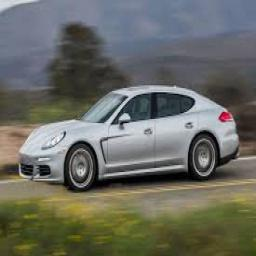

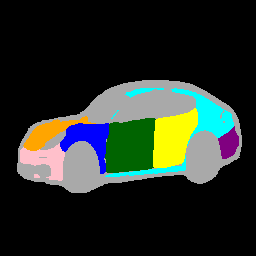

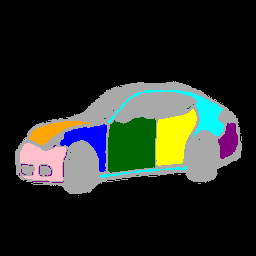

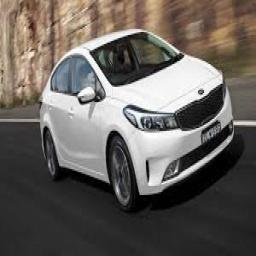

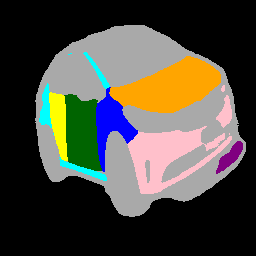

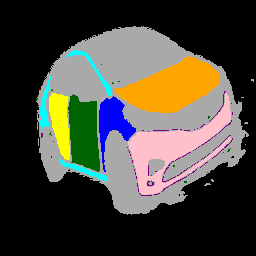

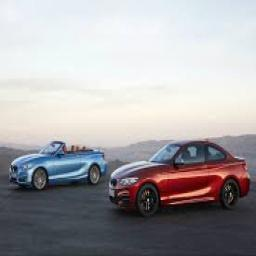

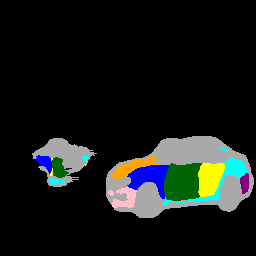

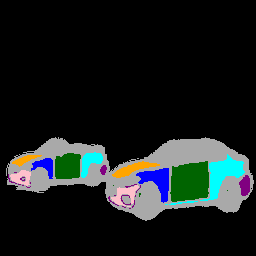

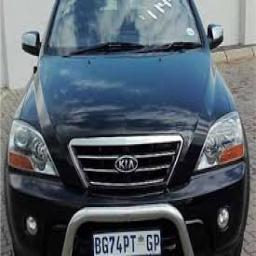

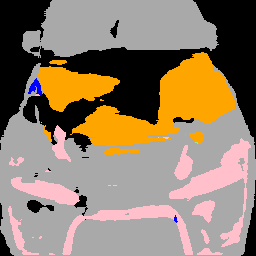

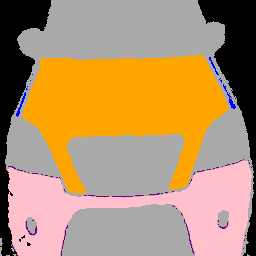

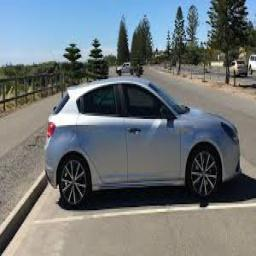

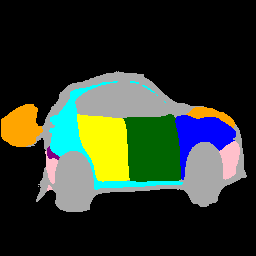

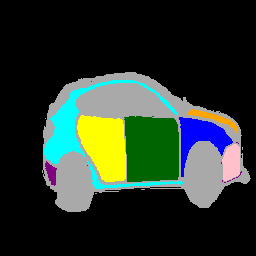

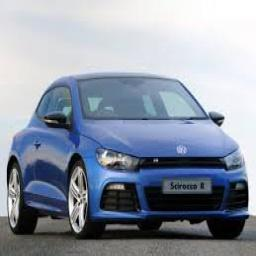

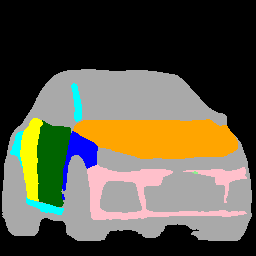

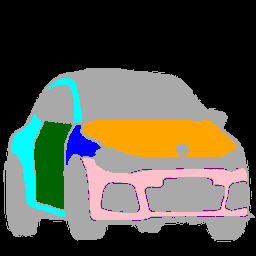

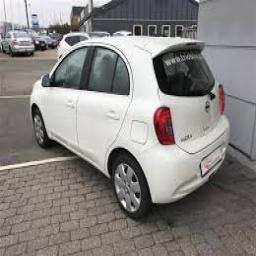

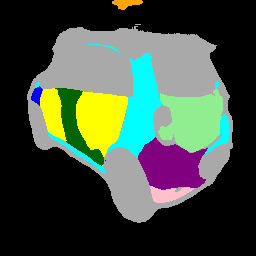

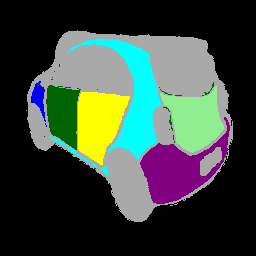

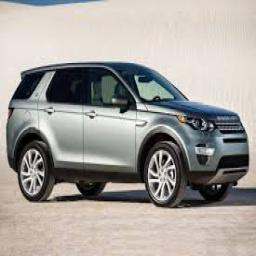

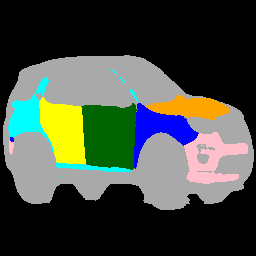

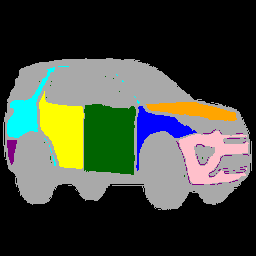

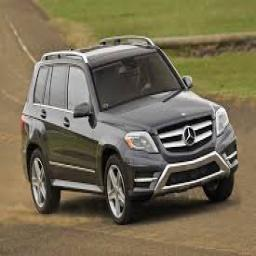

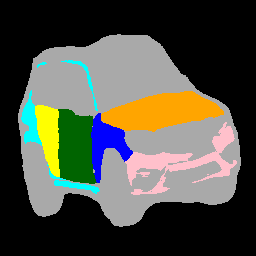

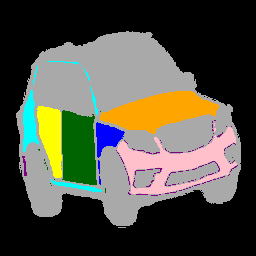

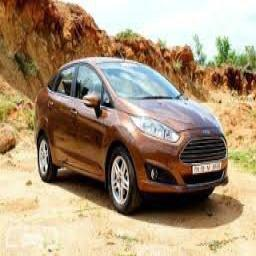

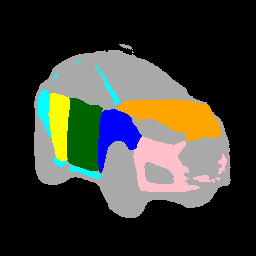

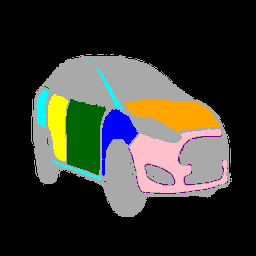

In [ ]:
for i in range(10):
  car, labels = test_ds[i]
  infere_display(weighted_model, car, labels)

# Weighted 2

In [ ]:
device = "cuda"
weighted_model2 = UNet(3, 10).to(device)
criterion = nn.CrossEntropyLoss(weight = torch.tensor([0.2, 1, 1, 1, 1, 1, 1, 1, 1, 0.6])).to(device)
optimizer = optim.Adam(weighted_model2.parameters(), lr=0.001, weight_decay=1e-5)

#checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/weighted_checkpoint_epoch_20.pth"
#checkpoint = torch.load(checkpoint_path)
#weighted_model2.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = 0 #checkpoint['epoch'] + 1

num_epochs = 200

dice = Dice(average='macro', num_classes=10)
dice_micro = Dice(average='micro')
dice_train = []
dice_val = []

for epoch in range(start_epoch, num_epochs):
    weighted_model2.train()
    total_train_loss = 0.0
    dice_scores_train = 0


    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.float()
        labels = labels.long().to(device)

        # Forward pass
        outputs = weighted_model2(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        total_train_loss += loss.item()

        # Calculate dice
        _, pred = torch.max(outputs, 1)
        pred_cpu = pred.to('cpu')
        labels_cpu = labels.to('cpu')

        dice_scores_train += dice(pred_cpu, labels_cpu)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    weighted_model2.eval()
    total_val_loss = 0.0
    dice_scores_val = 0
    micro_dice_scores_val = 0

    for batch in val_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.float()
        labels = labels.long().to(device)

        with torch.no_grad():
            outputs = weighted_model2(inputs)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

            # Calculate dice
            _, pred = torch.max(outputs, 1)
            pred_cpu = pred.to('cpu')
            labels_cpu = labels.to('cpu')

            dice_scores_val += dice(pred_cpu, labels_cpu)
            micro_dice_scores_val += dice_micro(pred_cpu, labels_cpu)


    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {(total_train_loss / len(train_loader)):.4f}, Train dice: {(dice_scores_train/len(train_loader)):.4f}, Val Loss: {(total_val_loss / len(val_loader)):.4f}, Val dice: {(dice_scores_val / len(val_loader)):.4f}, Val micro_dice: {(micro_dice_scores_val / len(val_loader)):.4f}")
    dice_train.append((dice_scores_train/len(train_loader)))
    dice_val.append((dice_scores_val/len(val_loader)))

    if (epoch + 1) % 10 == 0 or (micro_dice_scores_val / len(val_loader)) > 0.8779:
        checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/weighted2_checkpoint_epoch_{epoch + 1}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': weighted_model2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': total_train_loss / len(train_loader),
            'val_loss': total_val_loss / len(val_loader),
            'train_dice': dice_scores_train / len(train_loader),
            'val_dice': dice_scores_val / len(val_loader),
            'val_micro_dice': micro_dice_scores_val / len(val_loader)
        }, checkpoint_path)
        print(f"Checkpoint {epoch+1} saved")




In [ ]:
checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/weighted2_checkpoint_epoch_90.pth"
checkpoint = torch.load(checkpoint_path)
weighted_model2.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
multiclass_dice = F1Score(task='multiclass',num_classes=10,average="none")
weighted_model2.eval()

for batch in test_loader:
    inputs, labels = batch
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    inputs = inputs.float()
    labels = labels.long().to(device)

    with torch.no_grad():
        outputs = weighted_model2(inputs)

        # Calculate accuracy on the test set
        _, pred = torch.max(outputs, 1)

        # Move tensors to CPU before performing numpy operations
        pred_cpu = pred.to('cpu')
        labels_cpu = labels.to('cpu')
        m_dice = multiclass_dice(pred_cpu, labels_cpu)

    print(m_dice)



tensor([0.9629, 0.7266, 0.8539, 0.7589, 0.6195, 0.5647, 0.7174, 0.7638, 0.6181,
        0.8144])
tensor([0.9624, 0.7631, 0.7995, 0.6690, 0.3875, 0.3896, 0.6381, 0.7124, 0.7448,
        0.8064])


In [ ]:
macro = test_model(weighted_model2, test_loader, "macro")
micro = test_model(weighted_model2, test_loader, "micro")

print(f"Macro: {macro}")
print(f"Micro: {micro}")



Macro: 0.71364426612854
Micro: 0.8755965232849121


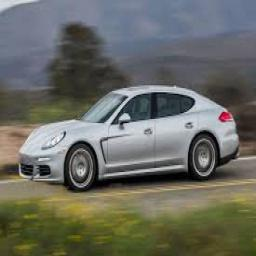

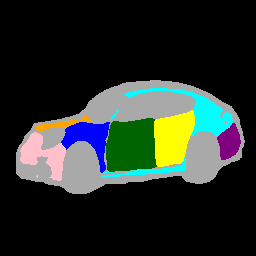

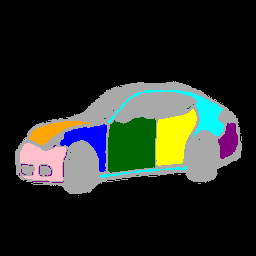

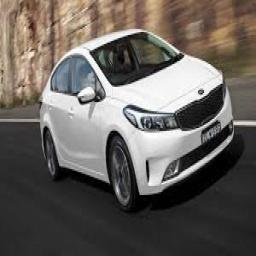

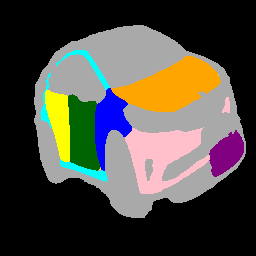

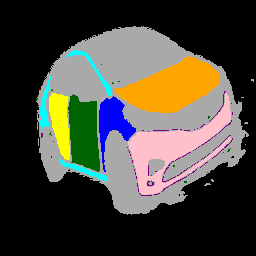

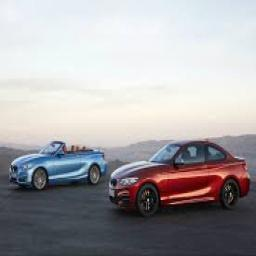

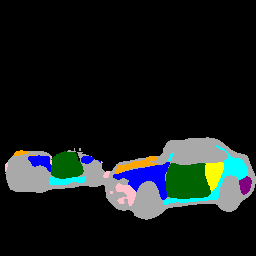

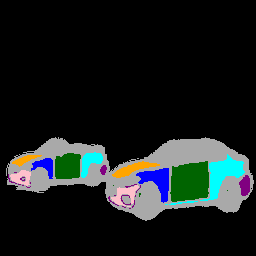

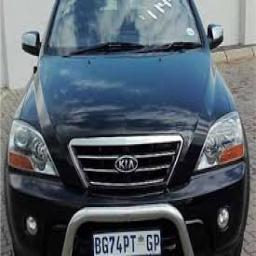

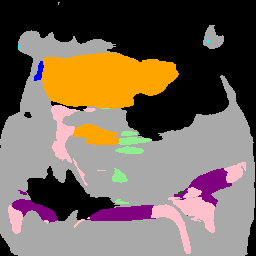

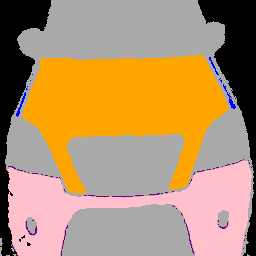

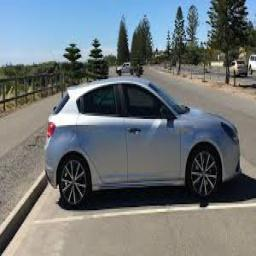

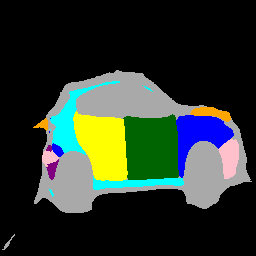

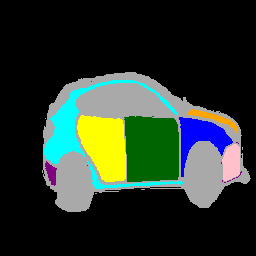

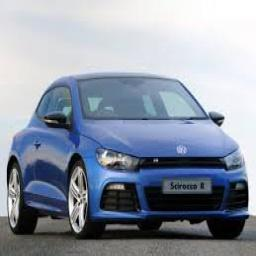

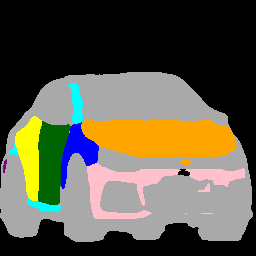

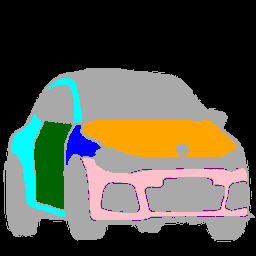

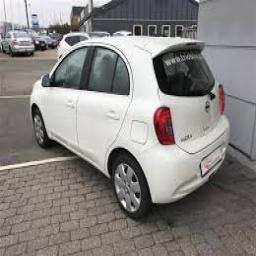

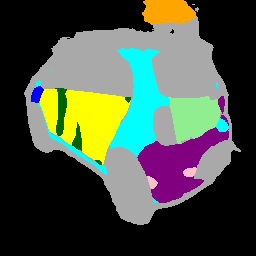

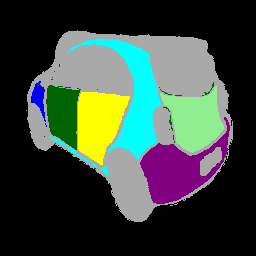

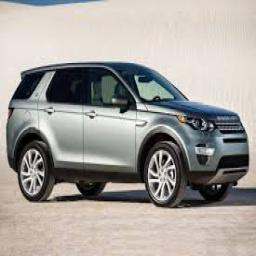

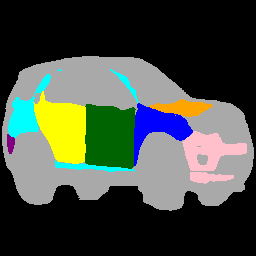

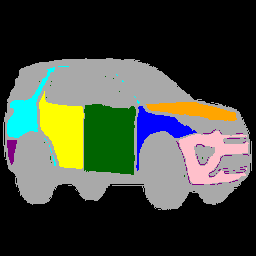

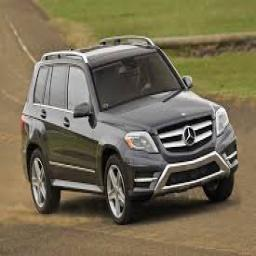

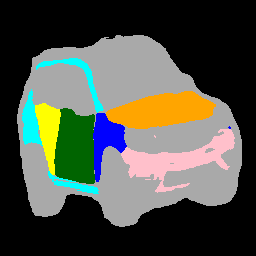

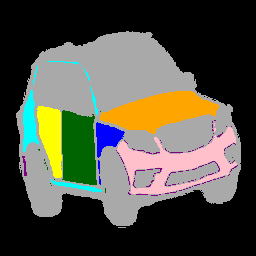

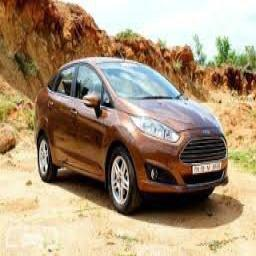

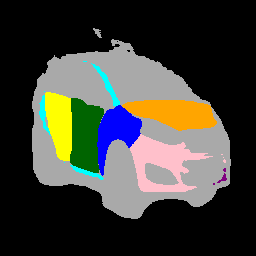

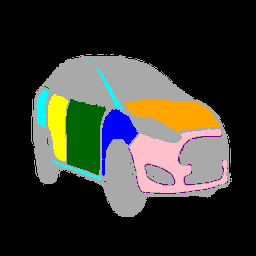

In [ ]:
for i in range(10):
  car, labels = test_ds[i]
  infere_display(weighted_model2, car, labels)

# Diceloss

In [ ]:
!pip install torchgeometry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 1.7 MB/s eta 0:00:00


In [ ]:
import torchgeometry as tgm

device = "cuda"
dice_model = UNet(3, 10).to(device)
criterion = tgm.losses.DiceLoss()
optimizer = optim.Adam(dice_model.parameters(), lr=0.01, weight_decay=1e-5)

checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/dice_checkpoint_epoch_200.pth"
checkpoint = torch.load(checkpoint_path)
dice_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

num_epochs = 300

dice = Dice(average='macro', num_classes=10)
dice_micro = Dice(average='micro')
dice_train = []
dice_val = []

for epoch in range(start_epoch, num_epochs):
    dice_model.train()
    total_train_loss = 0.0
    dice_scores_train = 0


    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.float()
        labels = labels.long().to(device)

        # Forward pass
        outputs = dice_model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        total_train_loss += loss.item()

        # Calculate dice
        _, pred = torch.max(outputs, 1)
        pred_cpu = pred.to('cpu')
        labels_cpu = labels.to('cpu')

        dice_scores_train += dice(pred_cpu, labels_cpu)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    dice_model.eval()
    total_val_loss = 0.0
    dice_scores_val = 0
    micro_dice_scores_val = 0

    for batch in val_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.float()
        labels = labels.long().to(device)

        with torch.no_grad():
            outputs = dice_model(inputs)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

            # Calculate dice
            _, pred = torch.max(outputs, 1)
            pred_cpu = pred.to('cpu')
            labels_cpu = labels.to('cpu')

            dice_scores_val += dice(pred_cpu, labels_cpu)
            micro_dice_scores_val += dice_micro(pred_cpu, labels_cpu)


    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {(total_train_loss / len(train_loader)):.4f}, Train dice: {(dice_scores_train/len(train_loader)):.4f}, Val Loss: {(total_val_loss / len(val_loader)):.4f}, Val dice: {(dice_scores_val / len(val_loader)):.4f}, Val micro_dice: {(micro_dice_scores_val / len(val_loader)):.4f}")
    dice_train.append((dice_scores_train/len(train_loader)))
    dice_val.append((dice_scores_val/len(val_loader)))

    if (epoch + 1) % 5 == 0 or (dice_scores_val / len(val_loader)) > 0.6832:
        checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/dice_checkpoint_epoch_{epoch + 1}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': dice_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': total_train_loss / len(train_loader),
            'val_loss': total_val_loss / len(val_loader),
            'train_dice': dice_scores_train / len(train_loader),
            'val_dice': dice_scores_val / len(val_loader),
            'val_micro_dice': micro_dice_scores_val / len(val_loader)
        }, checkpoint_path)
        print(f"Checkpoint {epoch+1} saved")




KeyboardInterrupt: ignored

In [ ]:
for i in range(10):
  car, labels = test_ds[i]
  infere_display(weighted_model, car, labels)

# Focal Loss

In [ ]:
!pip install torchgeometry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 1.3 MB/s eta 0:00:00


In [ ]:
import torchgeometry as tgm

device = "cuda"
focal_model = UNet(3, 10).to(device)
criterion = tgm.losses.FocalLoss(alpha=0.25, gamma=2.0, reduction='mean')
optimizer = optim.Adam(focal_model.parameters(), lr=0.01, weight_decay=1e-5)

checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/focal_checkpoint_epoch_200.pth"
checkpoint = torch.load(checkpoint_path)
focal_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

num_epochs = 400

dice = Dice(average='macro', num_classes=10)
dice_micro = Dice(average='micro')
dice_train = []
dice_val = []

for epoch in range(start_epoch, num_epochs):
    focal_model.train()
    total_train_loss = 0.0
    dice_scores_train = 0


    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.float()
        labels = labels.long().to(device)

        # Forward pass
        outputs = focal_model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        total_train_loss += loss.item()

        # Calculate dice
        _, pred = torch.max(outputs, 1)
        pred_cpu = pred.to('cpu')
        labels_cpu = labels.to('cpu')

        dice_scores_train += dice(pred_cpu, labels_cpu)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    focal_model.eval()
    total_val_loss = 0.0
    dice_scores_val = 0
    micro_dice_scores_val = 0

    for batch in val_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.float()
        labels = labels.long().to(device)

        with torch.no_grad():
            outputs = focal_model(inputs)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

            # Calculate dice
            _, pred = torch.max(outputs, 1)
            pred_cpu = pred.to('cpu')
            labels_cpu = labels.to('cpu')

            dice_scores_val += dice(pred_cpu, labels_cpu)
            micro_dice_scores_val += dice_micro(pred_cpu, labels_cpu)


    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {(total_train_loss / len(train_loader)):.4f}, Train dice: {(dice_scores_train/len(train_loader)):.4f}, Val Loss: {(total_val_loss / len(val_loader)):.4f}, Val dice: {(dice_scores_val / len(val_loader)):.4f}, Val micro_dice: {(micro_dice_scores_val / len(val_loader)):.4f}")
    dice_train.append((dice_scores_train/len(train_loader)))
    dice_val.append((dice_scores_val/len(val_loader)))

    if (epoch + 1) % 5 == 0 or (dice_scores_val / len(val_loader)) > 0.6832:
        checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/focal_checkpoint_epoch_{epoch + 1}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': focal_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': total_train_loss / len(train_loader),
            'val_loss': total_val_loss / len(val_loader),
            'train_dice': dice_scores_train / len(train_loader),
            'val_dice': dice_scores_val / len(val_loader),
            'val_micro_dice': micro_dice_scores_val / len(val_loader)
        }, checkpoint_path)
        print(f"Checkpoint {epoch+1} saved")




Epoch 201/400, Train Loss: 0.0720, Train dice: 0.3780, Val Loss: 0.0900, Val dice: 0.3725, Val micro_dice: 0.8032
Epoch 202/400, Train Loss: 0.0730, Train dice: 0.3745, Val Loss: 0.0923, Val dice: 0.3324, Val micro_dice: 0.8006
Epoch 203/400, Train Loss: 0.0731, Train dice: 0.3776, Val Loss: 0.0840, Val dice: 0.3765, Val micro_dice: 0.8154
Epoch 204/400, Train Loss: 0.0735, Train dice: 0.3705, Val Loss: 0.0863, Val dice: 0.3766, Val micro_dice: 0.8104
Epoch 205/400, Train Loss: 0.0717, Train dice: 0.3710, Val Loss: 0.0786, Val dice: 0.3864, Val micro_dice: 0.8224
Checkpoint 205 saved
Epoch 206/400, Train Loss: 0.0731, Train dice: 0.3726, Val Loss: 0.0836, Val dice: 0.3735, Val micro_dice: 0.8135
Epoch 207/400, Train Loss: 0.0740, Train dice: 0.3715, Val Loss: 0.0863, Val dice: 0.3706, Val micro_dice: 0.8037
Epoch 208/400, Train Loss: 0.0719, Train dice: 0.3757, Val Loss: 0.0780, Val dice: 0.3749, Val micro_dice: 0.8132
Epoch 209/400, Train Loss: 0.0715, Train dice: 0.3834, Val Loss: 0.

KeyboardInterrupt: ignored

# Pix2pix

In [ ]:
import torch.nn as nn

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(PatchGANDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),  # Adjust kernel_size and stride
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
device = "cuda"
generator = UNet(3, 10).to(device)
discriminator = PatchGANDiscriminator().to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
criterion_L1 = nn.L1Loss()
criterion_adv = nn.BCEWithLogitsLoss()

optimizer_gen = optim.Adam(generator.parameters(), lr=0.001, weight_decay=1e-4)
optimizer_dis = optim.Adam(discriminator.parameters(), lr=0.01)

In [ ]:
num_epochs = 200
dice = Dice(average='macro', num_classes=10).to(device)

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    total_gen_loss = 0.0
    total_dis_loss = 0.0

    for batch in train_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.float()
        labels = labels.long()

        # Train the discriminator
        optimizer_dis.zero_grad()
        fake_targets = generator(inputs)
        loss_gen_L1 = criterion(fake_targets, labels)

        fake_targets = torch.argmax(fake_targets, dim=1, keepdim=True)

        labels = labels.unsqueeze(1)
        labels = labels.float()

        real_preds = discriminator(labels)
        fake_preds = discriminator(fake_targets.detach().float())
        real_loss = criterion_adv(real_preds, torch.ones_like(real_preds))
        fake_loss = criterion_adv(fake_preds, torch.zeros_like(fake_preds))
        loss_dis = 0.5 * (real_loss + fake_loss)
        loss_dis.backward()
        optimizer_dis.step()

        # Train the generator
        optimizer_gen.zero_grad()
        fake_t_pred = discriminator(fake_targets.float())
        loss_gen_adv = criterion_adv(fake_t_pred, torch.ones_like(fake_t_pred))

        loss_gen = 0.4*loss_gen_adv + 0.8 * loss_gen_L1
        loss_gen.backward()
        optimizer_gen.step()

        total_dis_loss += loss_dis.item()
        total_gen_loss += loss_gen.item()

    avg_dis_loss = total_dis_loss / len(train_loader)
    avg_gen_loss = total_gen_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Generator Loss: {avg_gen_loss}, Discriminator Loss: {avg_dis_loss}")

    generator.eval()
    total_val_loss = 0.0
    total_dice = 0.0
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs = inputs.float()
        labels = labels.long()

        with torch.no_grad():
            val_outputs = generator(inputs)
            val_loss = criterion(val_outputs, labels)
            val_outputs = val_outputs.to(device)
            total_val_loss += val_loss.item()
            val_dice = dice(val_outputs, labels)
            total_dice += val_dice

    average_val_loss = total_val_loss / len(val_loader)
    average_dice = total_dice / len(val_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Generator Loss (Validation): {average_val_loss:.4f}, Dice: {average_dice:.4f}")

    if (epoch + 1) % 10 == 0 or average_dice > 66:
        checkpoint_path = f"{drive_path}carseg_data/models/checkpoint/pix2pix_checkpoint_epoch_{epoch + 1}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': generator.state_dict()
        }, checkpoint_path)
        print(f"Checkpoint {epoch+1} saved")


Epoch 1/200, Generator Loss: 0.8937511359944063, Discriminator Loss: 0.6931471824645996
Epoch 1/200, Generator Loss (Validation): 0.8983, Dice: 0.1777
Epoch 2/200, Generator Loss: 0.8916189775747412, Discriminator Loss: 0.6931471824645996
Epoch 2/200, Generator Loss (Validation): 0.8959, Dice: 0.1753
Epoch 3/200, Generator Loss: 0.87320998766843, Discriminator Loss: 0.6931471824645996
Epoch 3/200, Generator Loss (Validation): 0.8731, Dice: 0.1883
Epoch 4/200, Generator Loss: 0.8624066598275129, Discriminator Loss: 0.6931471824645996
Epoch 4/200, Generator Loss (Validation): 0.8452, Dice: 0.1820
Epoch 5/200, Generator Loss: 0.851782964257633, Discriminator Loss: 0.6931471824645996
Epoch 5/200, Generator Loss (Validation): 1.0280, Dice: 0.1610
Epoch 6/200, Generator Loss: 0.843234938733718, Discriminator Loss: 0.6931471824645996
Epoch 6/200, Generator Loss (Validation): 0.8766, Dice: 0.2134
Epoch 7/200, Generator Loss: 0.8400000368847567, Discriminator Loss: 0.6931471824645996
Epoch 7/20

In [ ]:
from torchmetrics import F1Score

In [ ]:
multiclass_dice = F1Score(task='multiclass',num_classes=10,average="none")
generator.eval()


for batch in test_loader:
    inputs, labels = batch
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    inputs = inputs.float()
    labels = labels.long().to(device)

    with torch.no_grad():
        outputs = generator(inputs)

        # Calculate accuracy on the test set
        _, pred = torch.max(outputs, 1)

        # Move tensors to CPU before performing numpy operations
        pred_cpu = pred.to('cpu')
        labels_cpu = labels.to('cpu')
        m_dice = multiclass_dice(pred_cpu, labels_cpu)

print(m_dice)

tensor([0.9525, 0.6151, 0.7788, 0.6963, 0.4654, 0.4121, 0.5641, 0.6338, 0.6728,
        0.7976])


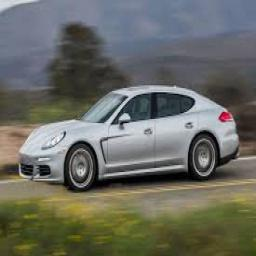

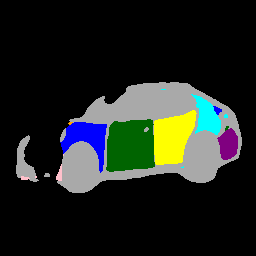

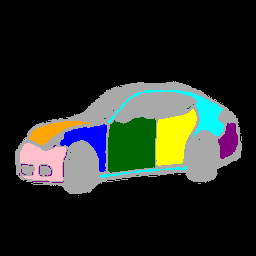

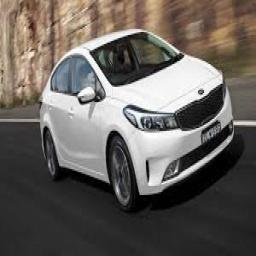

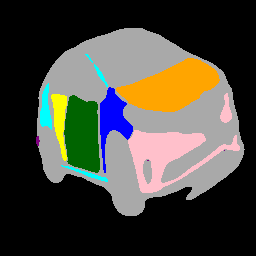

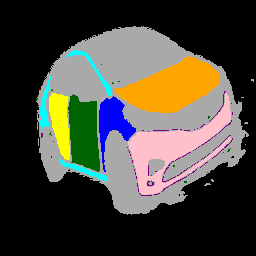

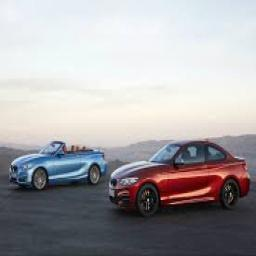

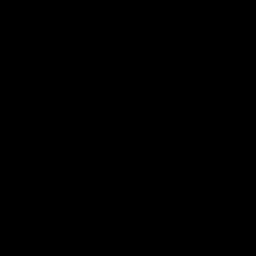

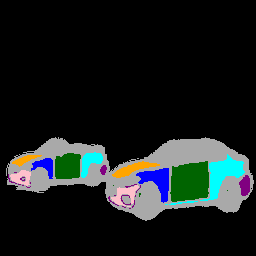

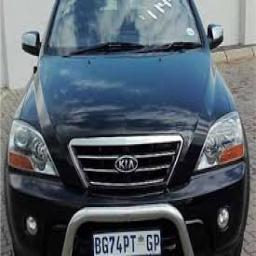

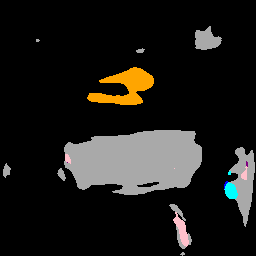

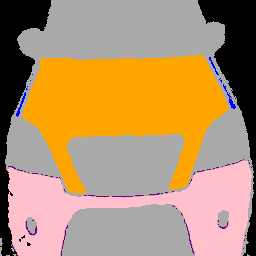

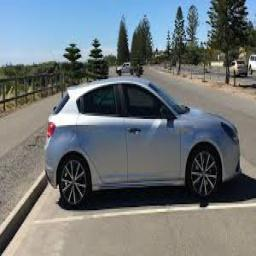

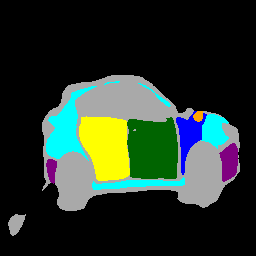

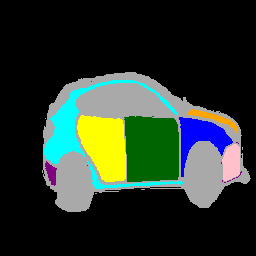

In [ ]:
for i in range(5):
  car, labels = test_ds[i]
  infere_display(generator, car, labels)

In [ ]:
macro = test_model(generator, test_loader, "macro")
micro = test_model(generator, test_loader, "micro")

print(f"Macro: {macro}")
print(f"Micro: {micro}")



Macro: 0.6456485986709595
Micro: 0.8567650318145752
